## Forward price evolution for various processes

In [1]:
import numpy as np
from typing import List
from datetime import date, timedelta
from numbers import Number
from forward_price_curve import ForwardPriceCurve, ForwardPrice, time_between
from price_process import PriceProcess
from price_evolution import display_evolving_fpc


We define a multi-factor process with exponentially decaying vols, $P(t, T)$, observing prices for delivery $T$ at time $t \leq T$ 

$$\frac{{\mathrm d}P(t, T)}{P(t, T)} = \Pi_{i=1}^Ne^{-\alpha_i (T - t)}\sigma_i {\mathrm d}z_i(t)$$

For ease of exposition the $\sigma_i$ are constants, however they could equally be functions of the delivery time $T$


In [2]:
class LognormalProcessWithExponentialDecay(PriceProcess):
    def __init__(self, alphas: List[Number], vols: List[Number]):
        super().__init__()
        self.alphas = alphas
        self.vols = vols
        self.num_factors = len(alphas)

    def evolve(self, fpc, next_observation_date):
        
        dt = time_between(fpc.observation_date, next_observation_date)
        dzs = [self.rng.normal(scale=np.sqrt(dt)) for _ in range(self.num_factors)]
        live_fpc = fpc.remove_deliveries_expiring_before(next_observation_date)

        evolved_prices = []
        for fp in live_fpc.forward_prices:
            evolved_price = fp.price
            time_to_delivery = (fp.day - fpc.observation_date).days / 365.0
            for dz, alpha, vol in zip(dzs, self.alphas, self.vols):
                scaled_vol = np.exp(-alpha * time_to_delivery) * vol
                evolved_price *= np.exp(scaled_vol * dz  - self.risk_adj(scaled_vol, dt))
            evolved_prices.append(ForwardPrice(fp.day, evolved_price))
            
        return ForwardPriceCurve(
            next_observation_date,
            evolved_prices
        )
    
    

Any process P(t, T) can have a mean reverting spot process added. As suggested we use the MA price as the value to which we revert (and for convenience use the price of the day exactly one month ahead as a proxy for the monthly price)

\begin{equation}
\frac{{\mathrm d}P^\prime(t, T)}{P^\prime(t, T)} = 
\begin{cases}
dP(t, T) + \kappa\left(P(t, t + \frac{1}{12}) - P(t, t)\right)dt + \sigma^\prime dz^\prime & \text{when }t=T \\
dP(t, T)& \text{when }t<T 
\end{cases}
\end{equation}



In [3]:
class ProcessWithAddedMeanRevertingSpotPrice(PriceProcess):
    def __init__(self, original_process, kappa, spot_vol):
        super().__init__()
        self.original_process = original_process
        self.kappa = kappa
        self.spot_vol = spot_vol
        
    def _drift(self, fpc, dt):
        spot_price = fpc.interpolated_price(fpc.observation_date)
        ma_price = fpc.interpolated_price(fpc.observation_date + timedelta(30))
        return (ma_price - spot_price) * self.kappa * dt
        
    def evolve(self, fpc, next_observation_date):
        # Spot only changes from previous day
        dt = 1.0 / 365
        
        # first evolve according to the original process
        fpc1 = self.original_process.evolve(fpc, next_observation_date)
        
        spot_price, *later_prices = fpc1.forward_prices
        
        # Keep the DA price fixed, so that interpolation doesn't spuriously move prices
        day_after_price = ForwardPrice(spot_price.day + timedelta(1), spot_price.price)
        
        dz = self.rng.normal(scale = np.sqrt(dt))
        evolved_spot_price = spot_price * np.exp(self.spot_vol * dz + self._drift(fpc, dt) - self.risk_adj(self.spot_vol, dt))
        return ForwardPriceCurve(
            next_observation_date,
            [evolved_spot_price, day_after_price] + later_prices
        )


As an initial example, we use a 2 factor process. One of the decay factors is $0$, which means a parallel shift is applied

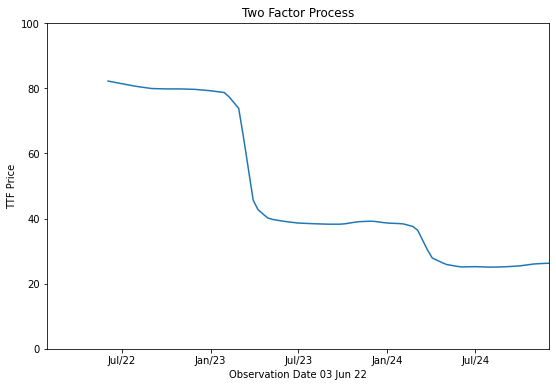

In [4]:
two_factor_process = LognormalProcessWithExponentialDecay(
    alphas=[0, 0.5],
    vols=[0.2, 0.7]
)

display_evolving_fpc(
    ForwardPriceCurve.jan_28_ttf_curve(),
    two_factor_process, 
    sleep_sec=0.1,
    title="Two Factor Process"
)

We next try adding a spot process, and focus on how prices evolve for the first couple of months

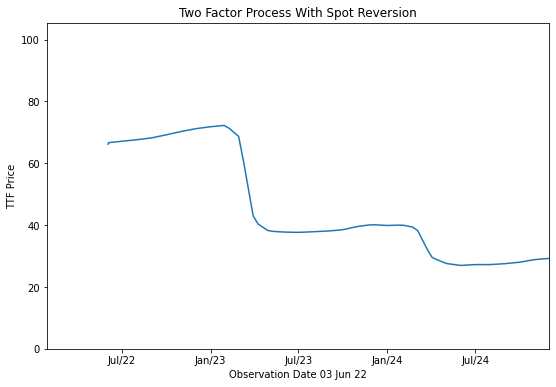

In [5]:
process_with_spot_reversion = ProcessWithAddedMeanRevertingSpotPrice(two_factor_process, kappa=0.4, spot_vol=0.3)
display_evolving_fpc(
    ForwardPriceCurve.jan_28_ttf_curve(),
    process_with_spot_reversion, 
    sleep_sec=0.1,
    title="Two Factor Process With Spot Reversion"
)